In [17]:
#импорт библиотек
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, adjusted_mutual_info_score
from scipy.sparse.linalg import eigsh
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn import metrics
from networkx.algorithms import community as nx_comm
from itertools import islice
from community import community_louvain

warnings.filterwarnings("ignore", category=UserWarning)

# Домашнее задание (24 баллов)

* Для задачи 1 используйте данные:[сеть](https://drive.google.com/file/d/1W5GrHAvxG4AjFm6kzwNyzoAA7jt48cJ5/view?usp=sharing), [метки вершин](https://drive.google.com/file/d/1dC-PWLIE2xGbHZwEgfplICTYZdCvwVxC/view).

* Для задачи 2,3 [данные](https://snap.stanford.edu/data/email-Eu-core.html) (предварительно сделайте сеть ненаправленной).

## 1. Классификация вершин (7 баллов)

Будем решать задачу предсказания влиятельности вершин как задачу бинарной классификации.

1. (1 балла) Разметьте вершины для бинарной классификации: постройте распределение влиятельностей и выберите порог разбиения на два отрезка.  

2. (2 балла) Вычислите различные структурные признаки вершин: центральности, кластеризацию, k-core

3. (2 балла)  Для каждой метрики центральности постройте AUC-ROC кривую и вычислите соответсвующую площадь. Какая из характеристик лучше классифицирует вершины?

4.  (2 балла) Постройте зависимость площади AUC-ROC от параметра альфа PageRank, определите оптимальное значение параметра.

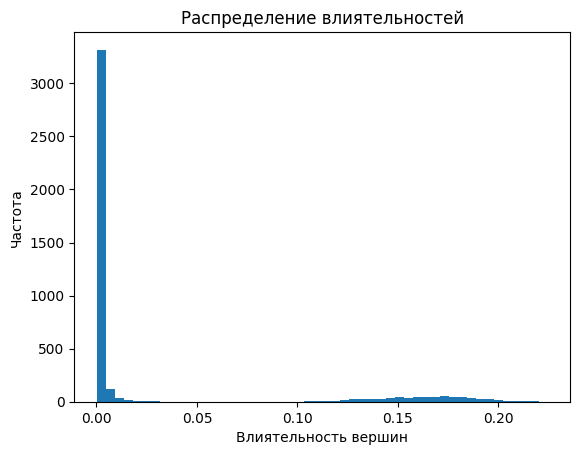

Количество значений 1: 646
Количество значений 0: 3512


In [18]:
G = nx.read_adjlist("ca-GrQc.mtx", create_using=nx.Graph(), nodetype=int)
data = pd.read_csv("spreading_data_ca-GrQc.csv")

labels = dict(zip(data['node'], data['spreading ability']))

# использование 'spreading ability' как меры влиятельности
influence = {node: labels[node] for node in G.nodes()}

plt.hist(list(influence.values()), bins=50)
plt.title('Распределение влиятельностей')
plt.xlabel('Влиятельность вершин')
plt.ylabel('Частота')
plt.show()

# порог разбиения
#threshold = 0.0004 # значение чтобы количество экземпляров класса примерно совпадало
threshold = 0.03

classified_nodes = {node: 1 if influence[node] > threshold else 0 for node in G.nodes()}
count_1 = sum(value == 1 for value in classified_nodes.values())
count_0 = sum(value == 0 for value in classified_nodes.values())

print(f"Количество значений 1: {count_1}")
print(f"Количество значений 0: {count_0}")

Центральность вершин:
{19: 0.0009622323791195574, 1: 0.0014433485686793362, 1751: 0.0007216742843396681, 2408: 0.0012027904738994468, 3078: 0.0007216742843396681, 3609: 0.0009622323791195574, 3958: 0.0012027904738994468, 612: 0.0009622323791195574, 2: 0.0009622323791195574, 2405: 0.00024055809477988935, 3096: 0.0019244647582391148, 3696: 0.0009622323791195574, 222: 0.0014433485686793362, 3: 0.0012027904738994468, 743: 0.005051719990377676, 1829: 0.002646139042578783, 2036: 0.005292278085157566, 2037: 0.006735626653836902, 1742: 0.0009622323791195574, 4: 0.0009622323791195574, 3017: 0.0009622323791195574, 3928: 0.0009622323791195574, 4043: 0.0019244647582391148, 3230: 0.0009622323791195574, 5: 0.00024055809477988935, 98: 0.01154678854943469, 6: 0.011787346644214578, 118: 0.013230695212893915, 190: 0.004089487611258119, 251: 0.013471253307673804, 351: 0.011306230454654799, 437: 0.015636276160692807, 471: 0.01082511426509502, 530: 0.011787346644214578, 674: 0.012990137118114024, 675: 0.00

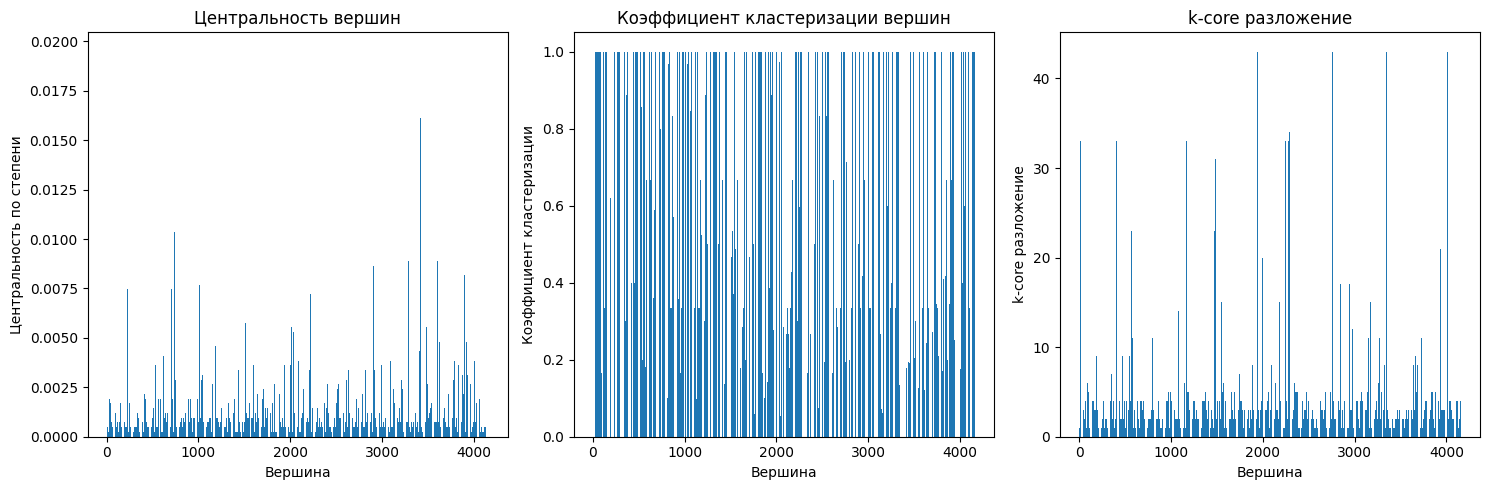

In [19]:
degree_centrality = nx.degree_centrality(G)
clustering_coefficient = nx.clustering(G)
k_core_number = nx.core_number(G)

print(f"Центральность вершин:\n{degree_centrality}")
print(f"\nКоэффициент кластеризации вершин:\n{clustering_coefficient}")
print(f"\nk-core разложение:\n{k_core_number}")

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.bar(degree_centrality.keys(), degree_centrality.values())
plt.xlabel('Вершина')
plt.ylabel('Центральность по степени')
plt.title('Центральность вершин')

plt.subplot(1,3,2)
plt.bar(clustering_coefficient.keys(), clustering_coefficient.values())
plt.xlabel('Вершина')
plt.ylabel('Коэффициент кластеризации')
plt.title('Коэффициент кластеризации вершин')

plt.subplot(1,3,3)
plt.bar(k_core_number.keys(), k_core_number.values())
plt.xlabel('Вершина')
plt.ylabel('k-core разложение')
plt.title('k-core разложение')

plt.tight_layout()
plt.show()

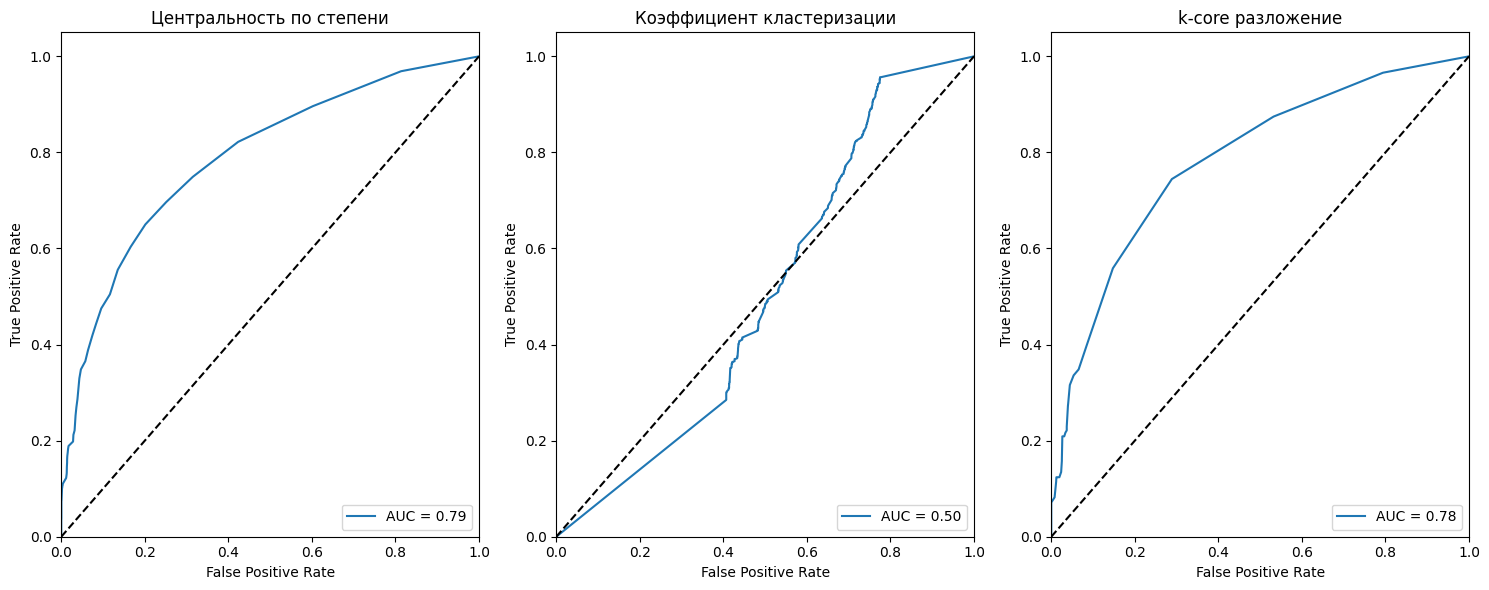

Центральность по степени лучше классифицирует вершины.


In [20]:
# AUC-ROC для центральности по степени
fpr_degree, tpr_degree, _ = roc_curve(list(classified_nodes.values()), list(degree_centrality.values()))
auc_degree = roc_auc_score(list(classified_nodes.values()), list(degree_centrality.values()))

# AUC-ROC для коэффициента кластеризации
fpr_clustering, tpr_clustering, _ = roc_curve(list(classified_nodes.values()), list(clustering_coefficient.values()))
auc_clustering = roc_auc_score(list(classified_nodes.values()), list(clustering_coefficient.values()))

# AUC-ROC для k-core разложения
fpr_k_core, tpr_k_core, _ = roc_curve(list(classified_nodes.values()), list(k_core_number.values()))
auc_k_core = roc_auc_score(list(classified_nodes.values()), list(k_core_number.values()))

fig, axs = plt.subplots(1, 3, figsize=(15, 6))

def plot_roc_curve_subplot(ax, fpr, tpr, auc_score, title):
    ax.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

plot_roc_curve_subplot(axs[0], fpr_degree, tpr_degree, auc_degree, 'Центральность по степени')
plot_roc_curve_subplot(axs[1], fpr_clustering, tpr_clustering, auc_clustering, 'Коэффициент кластеризации')
plot_roc_curve_subplot(axs[2], fpr_k_core, tpr_k_core, auc_k_core, 'k-core разложение')

plt.tight_layout()
plt.show()

best_metric = max(auc_degree, auc_clustering, auc_k_core)
if best_metric == auc_degree:
    print("Центральность по степени лучше классифицирует вершины.")
elif best_metric == auc_clustering:
    print("Коэффициент кластеризации лучше классифицирует вершины.")
else:
    print("k-core разложение лучше классифицирует вершины.")

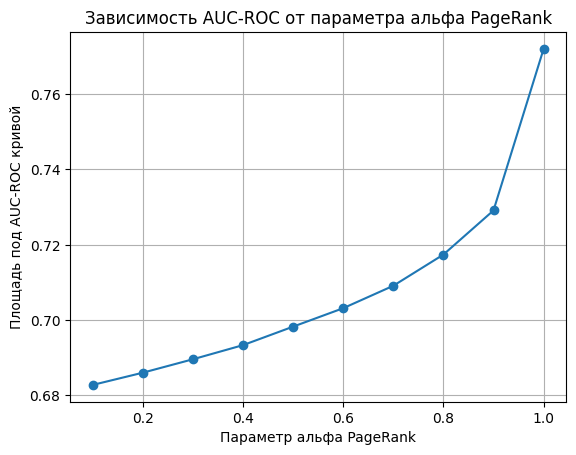

Оптимальное значение параметра альфа PageRank: 1.0


In [21]:
auc_scores = []

# PageRank
alpha_values = [i/10 for i in range(1, 11)]

for alpha in alpha_values:
    pagerank = nx.pagerank(G, alpha=alpha)
    auc_pagerank = roc_auc_score(list(classified_nodes.values()), list(pagerank.values()))
    auc_scores.append(auc_pagerank)

plt.plot(alpha_values, auc_scores, marker='o')
plt.xlabel('Параметр альфа PageRank')
plt.ylabel('Площадь под AUC-ROC кривой')
plt.title('Зависимость AUC-ROC от параметра альфа PageRank')
plt.grid(True)
plt.show()

optimal_alpha = alpha_values[auc_scores.index(max(auc_scores))]
print(f"Оптимальное значение параметра альфа PageRank: {optimal_alpha}")

## 2. Предсказание связей (9 баллов)

1. (1 балл) Разбейте сеть на обучающую и тестовую выборку, тестовая выборка должна содержать как связи, которые нужно предсказать, так и отсутствующие (выберите их случайным образом, чтобы тестовая выборка была сбалансирована).

2. (2 балла) Сравните Roc-кривые для различных структурных характеристик ребер в сети. Какая лучше справляется с задачей предсказания связей по AUC ROC?

3. (3 балла) Напишите функцию, вычисляющую  Average precision at K (ap@K), определите зависимость ap@K от K для простейших классификаторов, определенных в 2.

4. (3 балла) Постройте модель предсказания на основе вложения (используйте вложение сети с помощью Лапласиана) Сравните качество предсказания с простейшими классификаторами. Здесь можно взять любой бинарный классификатор, который вам нравится и обучить его на спектральных признаках. Исследуйте зависимость от размерности вложения.



In [22]:
edges_df = pd.read_csv('./email-Eu-core.txt', sep=' ', header=None, names=['source', 'target'])
labels_df = pd.read_csv('./email-Eu-core-department-labels.txt', sep=' ', header=None, names=['node', 'department'])

G = nx.from_pandas_edgelist(edges_df, 'source', 'target', create_using=nx.Graph())
G.remove_edges_from(nx.selfloop_edges(G))
G = G.to_undirected()

for _, row in labels_df.iterrows():
    G.nodes[row['node']]['department'] = row['department']

test_size=0.2
positive_edges = list(G.edges())
non_edges = list(nx.non_edges(G))
    
num_test_edges = int(len(positive_edges) * test_size)
positive_edges_test = np.random.choice(len(positive_edges), size=num_test_edges, replace=False)
non_edges_test = np.random.choice(len(non_edges), size=num_test_edges, replace=False)
    
test_edges = [positive_edges[i] for i in positive_edges_test] + [non_edges[i] for i in non_edges_test]
test_labels = [1] * num_test_edges + [0] * num_test_edges

num_train_edges = int(len(positive_edges) * (1 - test_size))
positive_edges_train = np.random.choice(len(positive_edges), size=num_train_edges, replace=False)
non_edges_train = np.random.choice(len(non_edges), size=num_train_edges, replace=False)

train_edges = [positive_edges[i] for i in positive_edges_train] + [non_edges[i] for i in non_edges_train]
train_labels = [1] * num_train_edges + [0] * num_train_edges
#print(f"{np.array(test_edges).shape}, {np.array(test_labels).shape}")
#print(f"{np.array(train_edges).shape}, {np.array(train_labels).shape}")

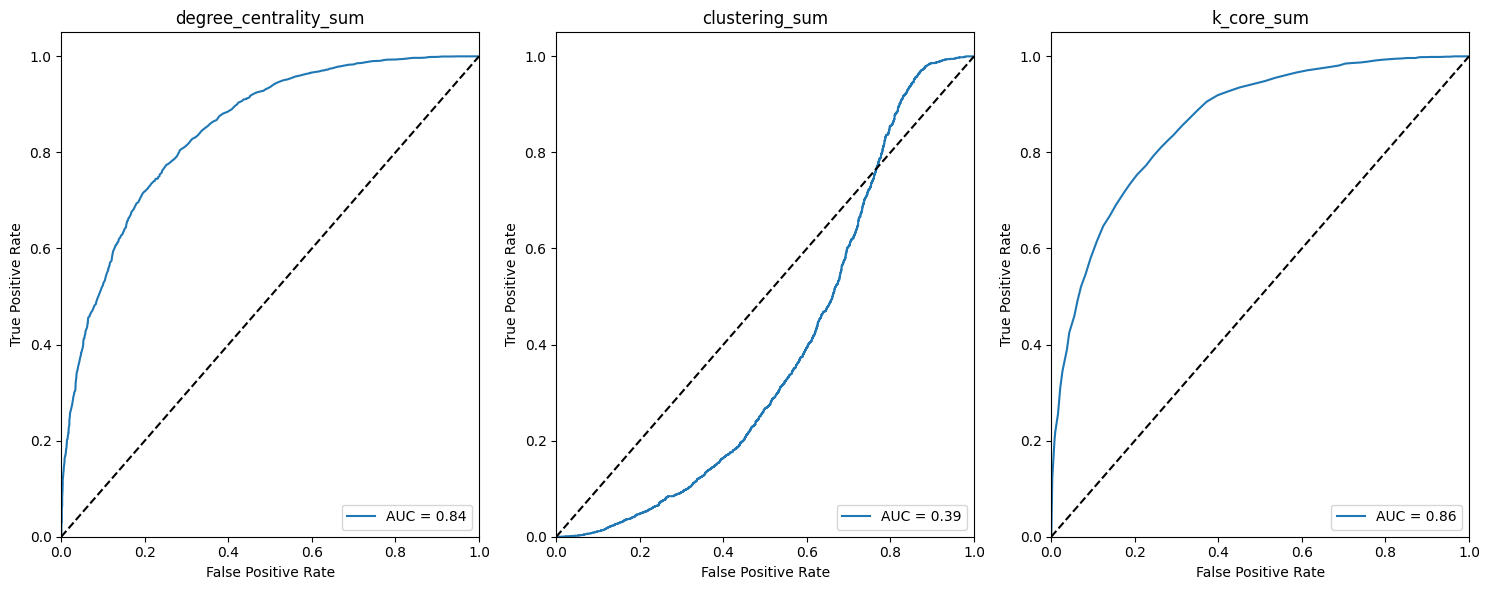

In [23]:
# вычисление структурных характеристик (из задачи 1)
degree_centrality = nx.degree_centrality(G)
clustering = nx.clustering(G)
k_core = nx.core_number(G)

test_features = {
    'degree_centrality_sum': [],
    'clustering_sum': [],
    'k_core_sum': []
}

# агрегирую по ребрам
for edge in test_edges:
    u, v = edge[0], edge[1]
    test_features['degree_centrality_sum'].append(degree_centrality[u] + degree_centrality[v])
    test_features['clustering_sum'].append(clustering[u] + clustering[v])
    test_features['k_core_sum'].append(k_core[u] + k_core[v])


def plot_roc_curve_subplot(ax, y_true, y_scores, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)
    
    ax.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

fig, axs = plt.subplots(1, len(test_features), figsize=(15, 6))

for idx, (feature_name, values) in enumerate(test_features.items()):
    ax = axs[idx]
    plot_roc_curve_subplot(ax, test_labels, values, title=feature_name)

plt.tight_layout()
plt.show()

___
**Вывод:** Сравнивая значения ROC AUC можно убедиться, что лучше всего справляется структурная хаарктеристика: k_core 
___

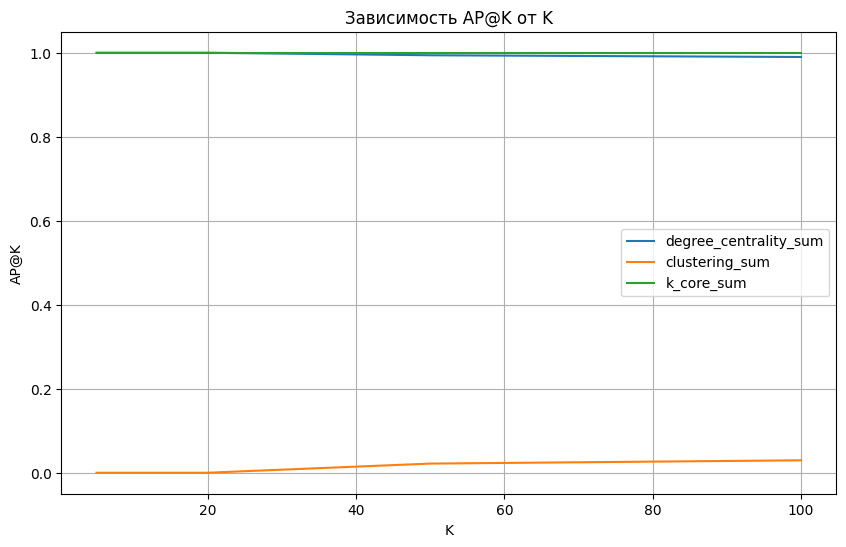

In [24]:
for key, value in test_features.items():
    test_features[key] = np.array(value)

def average_precision_at_k(y_true, y_scores, k):
    y_true = np.array(y_true)
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices][:k]
    num_positive = np.sum(y_true_sorted)
    precision_at_k = np.cumsum(y_true_sorted) / (np.arange(k) + 1)
    average_precision_at_k = np.sum(precision_at_k * y_true_sorted) / num_positive if num_positive > 0 else 0
    return average_precision_at_k

K_values = [5, 10, 15, 20, 50, 100]
feature_names = list(test_features.keys())
aps = {feature: [] for feature in feature_names}

for K in K_values:
    for feature_name in feature_names:
        score = average_precision_at_k(test_labels, test_features[feature_name], K)
        aps[feature_name].append(score)

plt.figure(figsize=(10, 6))
for feature_name, ap_scores in aps.items():
    plt.plot(K_values, ap_scores, label=feature_name)

plt.title('Зависимость AP@K от K')
plt.xlabel('K')
plt.ylabel('AP@K')
plt.legend()
plt.grid(True)
plt.show()

___
**Вывод:** для конкретно этой сети, наличие связей тесно связано с степенной центральною узлов, а так же с k-core. Также видно, что наличие связей между вершинами практически не зависит от суммарной кластеризации, что указывает на то, что плотность связей либо не оказывает, либо оказывает несущественной влияние для предсказания существования конкретной связи между вершинами.
___

AUC ROC (Логистическая регрессия на спектральных признаках): 0.5929


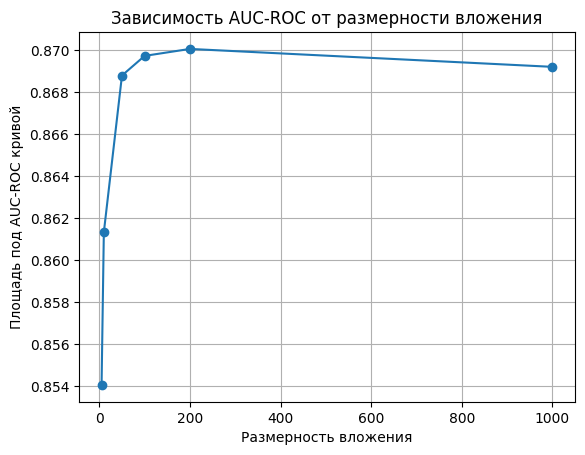

Лучшая точность 0.8700487276077101 достигается при размерности вложения 200


In [25]:
# Функция для создания вложения с помощью Лапласиана
def create_laplacian_embedding(G, dimension):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        laplacian = nx.normalized_laplacian_matrix(G).toarray().astype(float)
        _, eigenvects = eigsh(laplacian, k=dimension+1, which='SM')
    return eigenvects[:, 1:]  # Исключение первого собственного вектора

# Функция для создания признаков на основе результатов спектральной кластеризации
def create_features_from_spectral_clustering(G, num_clusters):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Graph is not fully connected, spectral embedding may not work as expected.", category=UserWarning)
        spectral_model = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', assign_labels='discretize', random_state=42)
        adjacency_matrix = nx.to_numpy_array(G)
        labels = spectral_model.fit_predict(adjacency_matrix)
        features = np.zeros((len(G.nodes()), num_clusters))
        for idx, cluster_label in enumerate(labels):
            features[idx, cluster_label] = 1
    
    return features

# обучение простого классификатора
num_clusters = 20
features = create_features_from_spectral_clustering(G, num_clusters)

X_train_cluster = np.array([features[u] + features[v] for u, v in train_edges])
X_test_cluster = np.array([features[u] + features[v] for u, v in test_edges])

scaler_cluster = StandardScaler()
X_train_cluster_scaled = scaler_cluster.fit_transform(X_train_cluster)
X_test_cluster_scaled = scaler_cluster.transform(X_test_cluster)
model_cluster = LogisticRegression(max_iter=1000)
model_cluster.fit(X_train_cluster_scaled, train_labels)

y_pred_proba_cluster = model_cluster.predict_proba(X_test_cluster_scaled)[:, 1]
roc_auc_cluster = roc_auc_score(test_labels, y_pred_proba_cluster)

print(f"AUC ROC (Логистическая регрессия на спектральных признаках): {roc_auc_cluster:.4f}")

# обучение на основе вложения
dimensions = [5, 10, 50, 100, 200, 1000]
roc = []
for dimension in dimensions:
    eigenvects = create_laplacian_embedding(G, dimension)
    X_train = np.array([eigenvects[u] + eigenvects[v] for u, v in train_edges])
    X_test = np.array([eigenvects[u] + eigenvects[v] for u, v in test_edges])
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    logistic_clf = LogisticRegression(max_iter=1000)
    logistic_clf.fit(X_train_scaled, train_labels)
    y_pred_proba_logistic = logistic_clf.predict_proba(X_test_scaled)[:, 1]
    roc_auc_logistic = roc_auc_score(test_labels, y_pred_proba_logistic)
    roc.append(roc_auc_logistic)

plt.plot(dimensions, roc, marker='o')
plt.xlabel('Размерность вложения')
plt.ylabel('Площадь под AUC-ROC кривой')
plt.title('Зависимость AUC-ROC от размерности вложения')
plt.grid(True)
plt.show()

print(f"Лучшая точность {max(roc)} достигается при размерности вложения {dimensions[roc.index(max(roc))]}")

___
**Вывод:** точность модели на основе вложения значительно лучше точности обычного классификатора. Также точность модели на основе вложение сети с помощью Лапласиана зависит от размерности вложения, из-за чего нужно подобрать оптимальный параметр, чтобы не ухудшить точность.
___

## 3. Задача кластеризации (8 баллов)

 Каждый сотдрудник относится к одному из департаментов, которые и являются истинными сообществами в сети.

1.  ( 2 балла) Постройте распределение размеров сообществ в сети, какова доля вершин в наибольшем сообществе? В наименьшем?

2. ( 2 балла) напишите функцию, вычисляющую [Rand индекс](https://en.wikipedia.org/wiki/Rand_index).

3. (2 балла) Рассмотрим задачу поиска сообществ с помощью агломеративного метода, постройте зависимость метрик качества (Rand индекс, взаимная информация, модулярность)  от числа задаваемых сообществ.
Какое разбиение оказывается более близким к истинному?

3. (2 балла) Определите сообщества любым другим методом (из семинара 9). Сколько сообществ вы получили? Сравните метрики качества.


Доля вершин в наибольшем сообществе: 0.10845771144278607
Доля вершин в наименьшем сообществе: 0.0009950248756218905


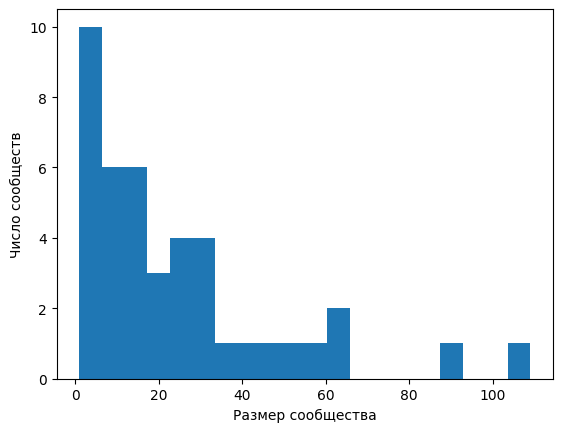

In [27]:
G = nx.read_edgelist("email-Eu-core.txt", nodetype=int)
G.remove_edges_from(nx.selfloop_edges(G))
G = G.to_undirected()
labels = {}
with open("email-Eu-core-department-labels.txt") as f:
    for line in f:
        node, label = map(int, line.strip().split())
        labels[node] = label
communities = {}
for node, label in labels.items():
    if label not in communities:
        communities[label] = []
    communities[label].append(node)

sizes = [len(nodes) for nodes in communities.values()]
largest_community_size = max(sizes)
smallest_community_size = min(sizes)
largest_community_ratio = largest_community_size / len(G.nodes())
smallest_community_ratio = smallest_community_size / len(G.nodes())

print("Доля вершин в наибольшем сообществе:", largest_community_ratio)
print("Доля вершин в наименьшем сообществе:", smallest_community_ratio)

plt.hist(sizes, bins=20)
plt.xlabel('Размер сообщества')
plt.ylabel('Число сообществ')
plt.show()

In [28]:
from itertools import combinations

def my_rand_index(true_labels, predicted_labels):
    tp_fp = 0  # TP + FP
    tn_fn = 0  # TN + FN
    n = len(true_labels)
    for i, j in combinations(range(n), 2):
        same_true_cluster = true_labels[i] == true_labels[j]
        same_predicted_cluster = predicted_labels[i] == predicted_labels[j]

        if same_true_cluster and same_predicted_cluster:
            tp_fp += 1
        elif not same_true_cluster and not same_predicted_cluster:
            tn_fn += 1

    rand_index = (tp_fp + tn_fn) / (n * (n - 1) / 2)
    return rand_index

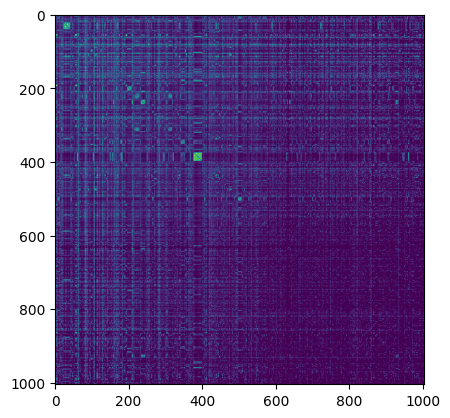

In [29]:
def similarity_matrix(G, nodelist=None): # nodelist задает порядок строк в матрице
    if (nodelist is None):
        nodelist=list(G.nodes)

    Smatrix=np.zeros((len(nodelist), len(nodelist)))

    for i, node1 in enumerate(nodelist):
        for j, node2 in enumerate(nodelist[i+1:], start = i+1):
            Smatrix[i,j]=(len(set(G[node1]) & set(G[node2])) + int(G.has_edge(node1,node2)))/(np.min([len(G[node1]),len(G[node2])])
                                                                                          +1-int(G.has_edge(node1,node2)))
            Smatrix[j,i]=Smatrix[i,j]

    return Smatrix

plt.imshow(similarity_matrix(G, nodelist=None))

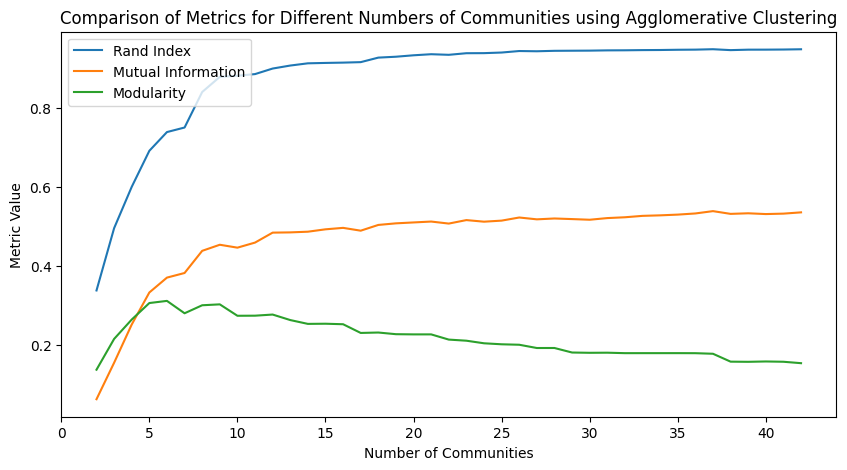

Оптимальное количество сообществ по Rand Index: 37 с метрикой 0.9499
Оптимальное количество сообществ по Mutual Information: 37 с метрикой 0.5391
Оптимальное количество сообществ по Modularity: 6 с метрикой 0.3113


In [30]:
num_communities = range(2, len(set(labels.values())) + 1)
rand = []
mutual_information = []
modularity = []

# создаем список узлов, который будет использоваться для отслеживания порядка во время кластеризации
nodes_list = sorted(G.nodes())
true_labels_list = [labels[node] for node in nodes_list]
X = similarity_matrix(G, nodelist=None)

for num_com in num_communities:
    model = AgglomerativeClustering(linkage='ward', n_clusters=num_com) #linkage='average' ~ 0.81 linkage='complete' ~ 0.9 linkage='ward' ~ 0.95
    model.fit(X)
    y_pred = model.labels_

    # Вычисление метрик
    rand.append(my_rand_index(true_labels_list, y_pred))
    mutual_information.append(adjusted_mutual_info_score(true_labels_list, y_pred))

    # Создание списка сообществ на основе предсказанных меток
    communities_pred = {i: set() for i in range(num_com)}
    for label, node in zip(y_pred, nodes_list):
        communities_pred[label].add(node)
    communities_pred = list(communities_pred.values())
    # Вычисление модулярности
    modularity.append(nx.algorithms.community.quality.modularity(G, communities_pred))

plt.figure(figsize=(10, 5))
plt.plot(num_communities, rand, label='Rand Index')
plt.plot(num_communities, mutual_information, label='Mutual Information')
plt.plot(num_communities, modularity, label='Modularity')
plt.xlabel('Number of Communities')
plt.ylabel('Metric Value')
plt.title('Comparison of Metrics for Different Numbers of Communities using Agglomerative Clustering')
plt.legend()
plt.show()

optimal_num_com_by_rand = num_communities[rand.index(max(rand))]
optimal_num_com_by_mi = num_communities[mutual_information.index(max(mutual_information))]
optimal_num_com_by_modularity = num_communities[modularity.index(max(modularity))]

print(f'Оптимальное количество сообществ по Rand Index: {optimal_num_com_by_rand} с метрикой {max(rand):.4f}')
print(f'Оптимальное количество сообществ по Mutual Information: {optimal_num_com_by_mi} с метрикой {max(mutual_information):.4f}')
print(f'Оптимальное количество сообществ по Modularity: {optimal_num_com_by_modularity} с метрикой {max(modularity):.4f}')

___
**Вывод:** разбиение на 41 сообщества получается наиболее близкое к истинному (42), причем метрика rand index при таком разбиении = 0.95, что является показателем отличного результата
___

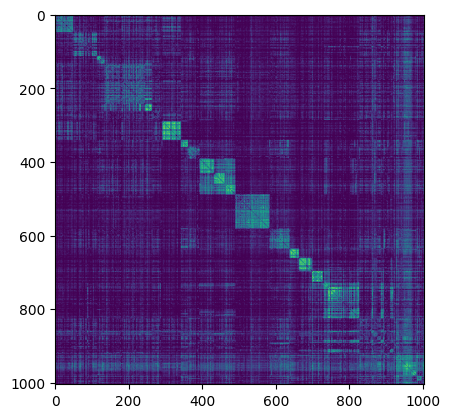

In [31]:
plt.imshow(similarity_matrix(G, nodelist=list(np.argsort(true_labels_list))))

Алгоритм Лювена (из семинара от 13.03.2024)

In [32]:
nodes = list(G.nodes())
partition = community_louvain.best_partition(G)
predicted_labels = [partition.get(node) for node in nodes]

rand_index = my_rand_index(true_labels_list, predicted_labels)
mutual_info = adjusted_mutual_info_score(true_labels_list, predicted_labels)
modularity = community_louvain.modularity(partition, G)
num_com = len(set(partition.values()))

print(f"Количество найденных сообществ: {num_com}")
print(f'Rand Index: {rand_index}')
print(f'Mutual Information: {mutual_info}')
print(f'Modularity: {modularity}')

Количество найденных сообществ: 26
Rand Index: 0.8359774831024162
Mutual Information: 0.521343912184795
Modularity: 0.41234522078828606


___
**Вывод:** количество разбиений по алгоритму Лювена получилось значительно меньше, чем у истинного, в отличии от количества разбиений агломеративного метода. Однако точность по Rand Index'у у обоих методов близка к единице. Значения Mutual Information у обоих подходов одинаковые. Modularity же второго подхода выше и указывает на гораздо более сильную структуру сообществ нежели у случайной сети, значение выше 0.3 указывает на сильную структуру сообществ. Таким образом, оба метода показали хорошие результаты кластеризации, однако наиболее близкое разбиение получилось у агломеративного метода.
___